# Main Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string, re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Bidirectional, Dropout

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading Data

In [4]:
data = pd.read_csv("/content/drive/MyDrive/Dataset/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Dataset/test.csv")

In [5]:
data.head(3)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1


In [6]:
test.head(314)

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...
...,...,...,...,...
309,21109,The Mysterious Metamorphosis of Chuck Close - ...,Wil S. Hylton,"A couple of weeks ago, I went to visit Chuck C..."
310,21110,Spring Weather? Snowstorm? New York Schools to...,Eli Rosenberg and Christopher Mele,The weather in New York City saw a 62 degr...
311,21111,Death to the Fascist Insect! The SLA and the Cops,Ron Jacobs,Email \nI was living in New York City when Pat...
312,21112,Ivana Says Young Donald Trump Was A Cry-Baby –...,Carrie MacDonald,Ivana Says Young Donald Trump Was A Cry-Baby –...


In [7]:
data.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [8]:
test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [9]:
data.shape, test.shape

((20800, 5), (5200, 4))

# Preprocessing Data & Analysis

## Drop Some Columns (ID, Author)

In [10]:
def drop_col(data):
    for col in ["id", "author"]: data.drop(col, axis=1, inplace=True)

    return data

data = drop_col(data)
test = drop_col(test)

In [11]:
data.head(2)

,title,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0


In [12]:
test.head(2)

,title,text
0,"Specter of Trump Loosens Tongues, if Not Purse...","PALO ALTO, Calif. — After years of scorning..."
1,Russian warships ready to strike terrorists ne...,Russian warships ready to strike terrorists ne...


In [13]:
data["title"].value_counts()

Get Ready For Civil Unrest: Survey Finds That Most Americans Are Concerned About Election Violence              5
The Dark Agenda Behind Globalism And Open Borders                                                               5
Schools All Over America Are Closing On Election Day Due To Fears Of Violence                                   4
“If Trump Loses, I’m Grabbing My Musket”: Former Congressman Ready to Go Full Revolution                        4
Public vs. Media on War                                                                                         4
                                                                                                               ..
Report: Only 6% of Millennials Said Their Social Media Was a ’Completely True’ Depiction of Them - Breitbart    1
Hillary Clinton, Donald Trump, Iraq Inquiry: Your Wednesday Evening Briefing - The New York Times               1
Shall We Save Civilization, or Not? - American Herald Tribune                           

In [14]:
data.isnull().sum()

title    558
text      39
label      0
dtype: int64

In [15]:
test.isnull().sum()

title    122
text       7
dtype: int64

In [16]:
test[test["text"].isnull()]

,title,text
589,[Vidéo] Que trouve-t-on dans « Le Gorafi de l’...,NaN
626,Nous avons comparé les programmes d’Alain Jupp...,NaN
978,« J’y crois encore ! » par Alain Juppé en trai...,NaN
2257,Horoscope du 14 novembre 2016 >> Le Gorafi,NaN
2892,Une fan demande le remboursement de son tatoua...,NaN
4736,Révélations – François Fillon serait de droite...,NaN
5092,Des traces de vin rouge détectées dans le Beau...,NaN


In [17]:
data[data["text"].isnull()]

,title,text,label
142,Gorafi Magazine : Entretien exclusif avec Bara...,NaN,1
573,Le top des recherches Google passe en top des ...,NaN,1
1200,La Corée du Nord annonce avoir envoyé un missi...,NaN,1
1911,Grand-Prix du Brésil – Romain Grosjean obtient...,NaN,1
2148,Gorafi Magazine: Barack Obama « Je vous ai déj...,NaN,1
2169,"#NDDL: Pour fêter l’autorisation des travaux, ...",NaN,1
2793,«Pourquoi je suis candidat à la présidentielle...,NaN,1
3329,GuinessBook : 100 millions d’Américains batten...,NaN,1
3729,Les Américains ne sont plus qu’à quelques heur...,NaN,1
4288,Hillary Clinton en 5 dates >> Le Gorafi,NaN,1


##  Filling Some Data (TEXT, TITLE)

In [18]:
def fill_data(data):
    data["title"] = data["title"].fillna("No Title")
    data["text"] = data["text"].fillna("No text")
    return data

data = fill_data(data)
test = fill_data(test)

In [19]:
data.isnull().sum()

title    0
text     0
label    0
dtype: int64

In [20]:
test.isnull().sum()

title    0
text     0
dtype: int64

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20800 non-null  object
 1   text    20800 non-null  object
 2   label   20800 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 487.6+ KB


In [22]:
data.head(2)

,title,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0


In [23]:
test.head(2)

,title,text
0,"Specter of Trump Loosens Tongues, if Not Purse...","PALO ALTO, Calif. — After years of scorning..."
1,Russian warships ready to strike terrorists ne...,Russian warships ready to strike terrorists ne...


In [24]:
data["new_text"] = data["title"] + " " + data["text"]
test["new_text"] = test["title"] + " " + test["text"]

In [25]:
data.head(2)

,title,text,label,new_text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."


In [26]:
test.head(2)

,title,text,new_text
0,"Specter of Trump Loosens Tongues, if Not Purse...","PALO ALTO, Calif. — After years of scorning...","Specter of Trump Loosens Tongues, if Not Purse..."
1,Russian warships ready to strike terrorists ne...,Russian warships ready to strike terrorists ne...,Russian warships ready to strike terrorists ne...


# Make Processing In Text

### Transform Upper Case To lower Case & Remove All Punctiuation & Remove Stop Words

In [27]:
punc = list(string.punctuation)
stop_words = stopwords.words("english")

def processing_text(data):
    data.lower()

    data = " ".join([word for word in word_tokenize(data) if ((word not in stop_words) and (word not in punc))])

    data = re.sub("[^a-z]", " ", data)

    return data

In [28]:
data["Final_text"] = data["new_text"].apply(processing_text)
test["Final_text"] = test["new_text"].apply(processing_text)

In [29]:
data.head(5)

,title,text,label,new_text,Final_text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...,ouse em ide e idn ven ee omey ett...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",illary linton ig oman ampus reitba...
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Why the Trut...,hy ruth ight et ou ired hy ruth ight ...
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...,ivilians illed n ingle irstrike av...
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...,ranian woman jailed fictional unpublished sto...


In [30]:
test.head(5)

,title,text,new_text,Final_text
0,"Specter of Trump Loosens Tongues, if Not Purse...","PALO ALTO, Calif. — After years of scorning...","Specter of Trump Loosens Tongues, if Not Purse...",pecter rump oosens ongues ot urse tring...
1,Russian warships ready to strike terrorists ne...,Russian warships ready to strike terrorists ne...,Russian warships ready to strike terrorists ne...,ussian warships ready strike terrorists near ...
2,#NoDAPL: Native American Leaders Vow to Stay A...,Videos #NoDAPL: Native American Leaders Vow to...,#NoDAPL: Native American Leaders Vow to Stay A...,o ative merican eaders ow tay ll i...
3,"Tim Tebow Will Attempt Another Comeback, This ...","If at first you don’t succeed, try a different...","Tim Tebow Will Attempt Another Comeback, This ...",im ebow ill ttempt nother omeback his ...
4,Keiser Report: Meme Wars (E995),42 mins ago 1 Views 0 Comments 0 Likes 'For th...,Keiser Report: Meme Wars (E995) 42 mins ago 1 ...,eiser eport eme ars mins ago ie...


# Drop Columns (new_text, title, text)

In [31]:
def drop_extra_col(data):
    for col in ["title", "text", "new_text"]: data.drop(col, axis=1, inplace=True)

    return data

data = drop_extra_col(data)
test = drop_extra_col(test)

In [32]:
data.head(5)

,label,Final_text
0,1,ouse em ide e idn ven ee omey ett...
1,0,illary linton ig oman ampus reitba...
2,1,hy ruth ight et ou ired hy ruth ight ...
3,1,ivilians illed n ingle irstrike av...
4,1,ranian woman jailed fictional unpublished sto...


In [33]:
test.head(5)

,Final_text
0,pecter rump oosens ongues ot urse tring...
1,ussian warships ready strike terrorists near ...
2,o ative merican eaders ow tay ll i...
3,im ebow ill ttempt nother omeback his ...
4,eiser eport eme ars mins ago ie...


# Splitting Data

In [34]:
X = data["Final_text"]
Y = data["label"]

In [35]:
label = np.array(Y)

In [36]:
label

array([1, 0, 1, ..., 0, 1, 1])

# Make Tokenization

In [37]:
Max_vocab_size = 20000
max_sequance_length = 100
Embeding_dim = 100

In [38]:
tokenize = Tokenizer(oov_token="<OOV>")
tokenize.fit_on_texts(X)
word_idx = tokenize.word_index

text2seq = tokenize.texts_to_sequences(X)

pad_seq = pad_sequences(text2seq, padding="pre", truncating="pre")


print("The Padding Sequance Shape is  --> ", pad_seq.shape)

The Padding Sequance Shape is  -->  (20800, 12815)


In [39]:
input_length = max(len(seq) for seq in text2seq)

vocabulary_size = len(word_idx) + 1

In [40]:
input_length, vocabulary_size

(12815, 151340)

In [42]:
x_train, x_Test, y_train, y_Test = train_test_split(pad_seq, label, train_size=0.6, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_Test, y_Test, train_size = 0.6)

# Building Model

In [43]:
model_1 = tf.keras.models.Sequential(
    [
        Embedding(vocabulary_size, 16, input_length=input_length),
        GlobalAveragePooling1D(),
        Dense(128, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

model_2 = tf.keras.models.Sequential(
    [
        Embedding(vocabulary_size, 16, input_length=input_length),
        GlobalAveragePooling1D(),
        Dense(128, activation="relu"),
        Dense(24, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

model_3 = tf.keras.models.Sequential(
    [
        Embedding(vocabulary_size, 16, input_length=input_length),
        GlobalAveragePooling1D(),
        Dense(128, activation="relu"),
        Dense(64, activation="relu"),
        Dense(24, activation="relu"),
        Dense(1, activation="sigmoid")
    ])


In [44]:
models = [model_1, model_2, model_3]
h_layers = []

for model in models:
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(
        x_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(x_val, y_val),
    )
    h_layers.append(history)

Epoch 1/10
390/390 [==============================] - 37s 93ms/step - loss: 0.6931 - accuracy: 0.5044 - val_loss: 0.6924 - val_accuracy: 0.5021
Epoch 2/10
390/390 [==============================] - 38s 98ms/step - loss: 0.6727 - accuracy: 0.6151 - val_loss: 0.6300 - val_accuracy: 0.5835
Epoch 3/10
390/390 [==============================] - 36s 92ms/step - loss: 0.4942 - accuracy: 0.7919 - val_loss: 0.3941 - val_accuracy: 0.8050
Epoch 4/10
390/390 [==============================] - 28s 72ms/step - loss: 0.3235 - accuracy: 0.8792 - val_loss: 0.3232 - val_accuracy: 0.8275
Epoch 5/10
390/390 [==============================] - 29s 75ms/step - loss: 0.2381 - accuracy: 0.9199 - val_loss: 0.2358 - val_accuracy: 0.9285
Epoch 6/10
390/390 [==============================] - 31s 79ms/step - loss: 0.1907 - accuracy: 0.9384 - val_loss: 0.2017 - val_accuracy: 0.9384
Epoch 7/10
390/390 [==============================] - 30s 77ms/step - loss: 0.1549 - accuracy: 0.9532 - val_loss: 0.1772 - val_accuracy:

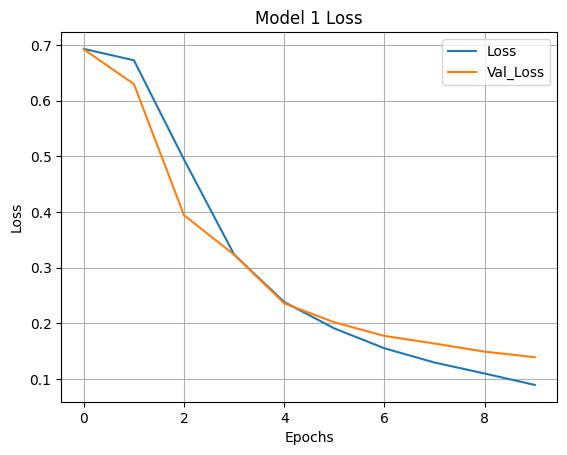

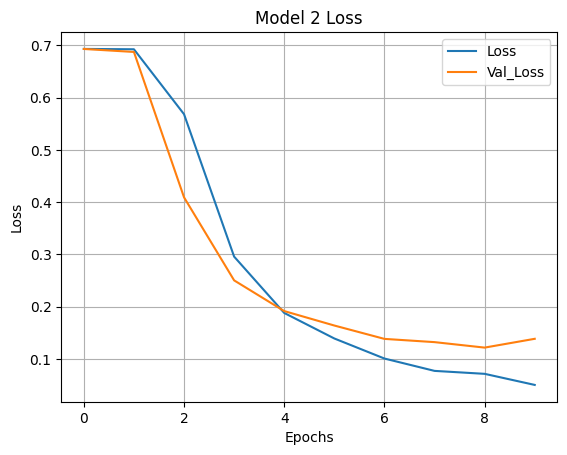

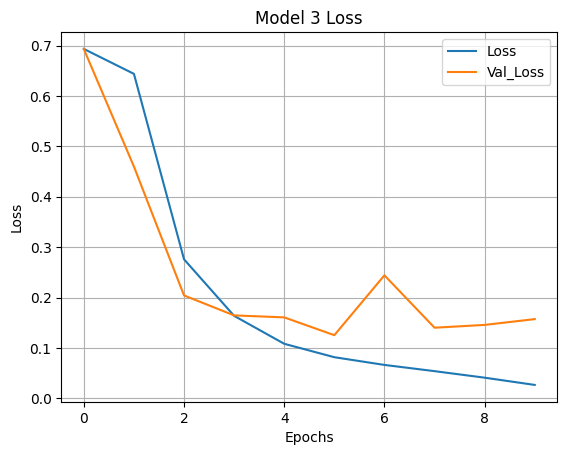

In [45]:
i = 1
for history in h_layers:
    plt.plot(history.history["loss"], label="Loss")
    plt.plot(history.history["val_loss"], label="Val_Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.title(f'Model {i} Loss')

    plt.legend()
    plt.grid()
    plt.show()
    i+=1

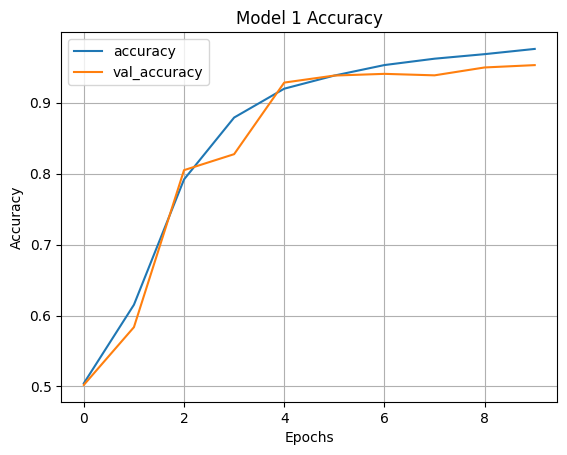

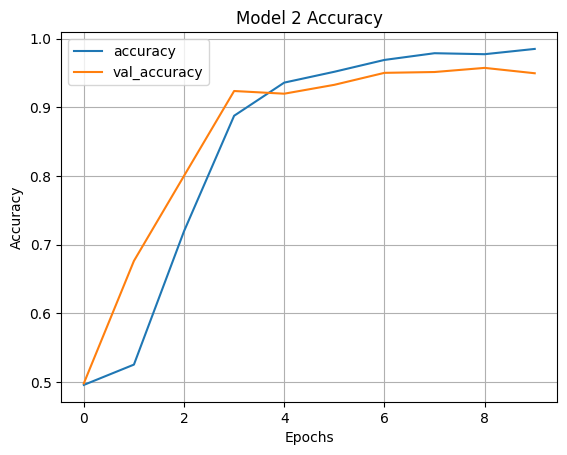

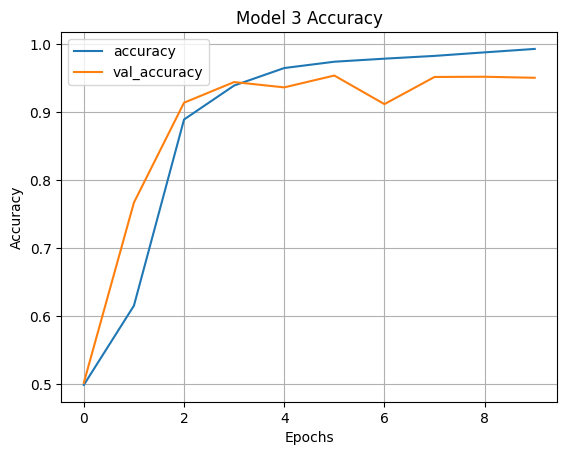

In [46]:
i = 1
for history in h_layers:
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.title(f'Model {i} Accuracy')

    plt.legend()
    plt.grid()
    plt.show()
    i+=1

In [47]:
i = 1
for model in models:
    score = model.evaluate(x_test, y_test)
    print(f'Model {i}')
    print("Test loss: ", score[0])
    print("Test accuracy: ", score[1])
    i+=1

156/156 [==============================] - 2s 15ms/step - loss: 0.1412 - accuracy: 0.9533
Model 1
Test loss:  0.14123950898647308
Test accuracy:  0.9533253312110901
156/156 [==============================] - 3s 18ms/step - loss: 0.1369 - accuracy: 0.9525
Model 2
Test loss:  0.13691508769989014
Test accuracy:  0.9525240659713745
156/156 [==============================] - 3s 17ms/step - loss: 0.1435 - accuracy: 0.9537
Model 3
Test loss:  0.1435292810201645
Test accuracy:  0.9537259340286255


## **SGD Optimizer**

In [48]:
model = tf.keras.models.Sequential(
    [
        Embedding(vocabulary_size, 16, input_length=input_length),
        GlobalAveragePooling1D(),
        Dense(128, activation="relu"),
        Dense(24, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

model.compile(optimizer="sgd", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_val, y_val),
)

Epoch 1/10
390/390 [==============================] - 28s 69ms/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.5018
Epoch 2/10
390/390 [==============================] - 26s 66ms/step - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6931 - val_accuracy: 0.5012
Epoch 3/10
390/390 [==============================] - 21s 54ms/step - loss: 0.6932 - accuracy: 0.4979 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 4/10
390/390 [==============================] - 24s 61ms/step - loss: 0.6932 - accuracy: 0.4985 - val_loss: 0.6931 - val_accuracy: 0.4991
Epoch 5/10
390/390 [==============================] - 21s 54ms/step - loss: 0.6932 - accuracy: 0.4978 - val_loss: 0.6931 - val_accuracy: 0.5018
Epoch 6/10
390/390 [==============================] - 27s 69ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6931 - val_accuracy: 0.5018
Epoch 7/10
390/390 [==============================] - 20s 52ms/step - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6931 - val_accuracy:

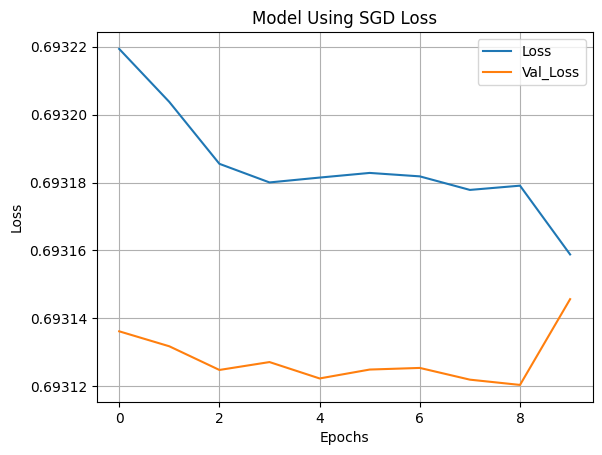

In [49]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Val_Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.title(f'Model Using SGD Loss')

plt.legend()
plt.grid()

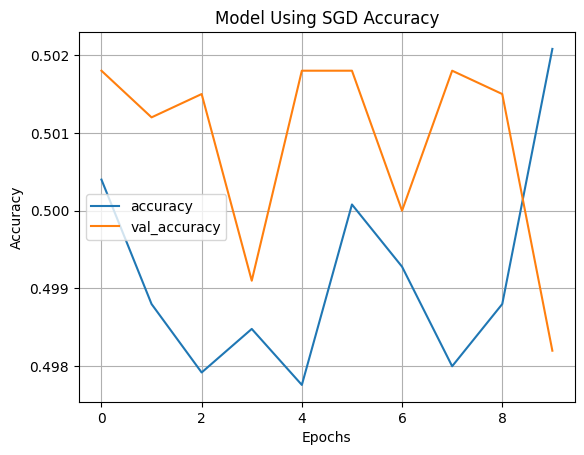

In [50]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title(f'Model Using SGD Accuracy')

plt.legend()
plt.grid()

In [51]:
score = model.evaluate(x_test, y_test)
print(f'Model SGD')
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

156/156 [==============================] - 2s 14ms/step - loss: 0.6931 - accuracy: 0.5006
Model SGD
Test loss:  0.6931265592575073
Test accuracy:  0.5006009340286255


# **Different Data Sizes**

In [41]:
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(pad_seq, label, train_size=0.6, random_state=42)
x0, x1, y0, y1 = train_test_split(x_test_1, y_test_1, train_size = 0.6)
first = [x_train_1, x_test_1, y_train_1, y_test_1, x0, x1, y0, y1]

x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(pad_seq, label, train_size=0.7, random_state=42)
x3, x4, y3, y4 = train_test_split(x_test_4, y_test_4, train_size = 0.6)
second = [x_train_4, x_test_4, y_train_4, y_test_4, x3, x4, y3, y4]

x_train_7, x_test_7, y_train_7, y_test_7 = train_test_split(pad_seq, label, train_size=0.8, random_state=42)
x6, x7, y6, y7 = train_test_split(x_test_7, y_test_7, train_size = 0.6)
third = [x_train_7, x_test_7, y_train_7, y_test_7, x6, x7, y6, y7]

datasize = [first, second, third]

In [42]:
model = tf.keras.models.Sequential(
    [
        Embedding(vocabulary_size, 16, input_length=input_length),
        GlobalAveragePooling1D(),
        Dense(128, activation="relu"),
        Dense(24, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

h_layers = []

for data in datasize:
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(
        data[0], data[2],
        epochs=10,
        batch_size=32,
        validation_data=(data[5], data[7]),
    )
    h_layers.append(history)

Epoch 1/10
390/390 [==============================] - 34s 85ms/step - loss: 0.6931 - accuracy: 0.5045 - val_loss: 0.6931 - val_accuracy: 0.4994
Epoch 2/10
390/390 [==============================] - 32s 81ms/step - loss: 0.6459 - accuracy: 0.6180 - val_loss: 0.5033 - val_accuracy: 0.7443
Epoch 3/10
390/390 [==============================] - 33s 84ms/step - loss: 0.3367 - accuracy: 0.8684 - val_loss: 0.2519 - val_accuracy: 0.8870
Epoch 4/10
390/390 [==============================] - 31s 80ms/step - loss: 0.1933 - accuracy: 0.9314 - val_loss: 0.1885 - val_accuracy: 0.9381
Epoch 5/10
390/390 [==============================] - 31s 81ms/step - loss: 0.1418 - accuracy: 0.9506 - val_loss: 0.1878 - val_accuracy: 0.9411
Epoch 6/10
390/390 [==============================] - 31s 80ms/step - loss: 0.1005 - accuracy: 0.9692 - val_loss: 0.1713 - val_accuracy: 0.9489
Epoch 7/10
390/390 [==============================] - 31s 79ms/step - loss: 0.0857 - accuracy: 0.9727 - val_loss: 0.1371 - val_accuracy:

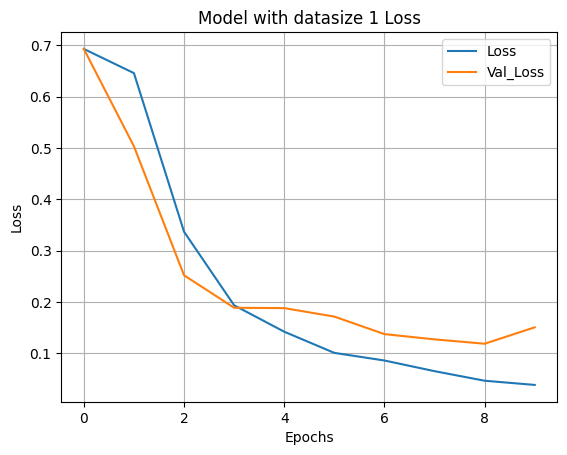

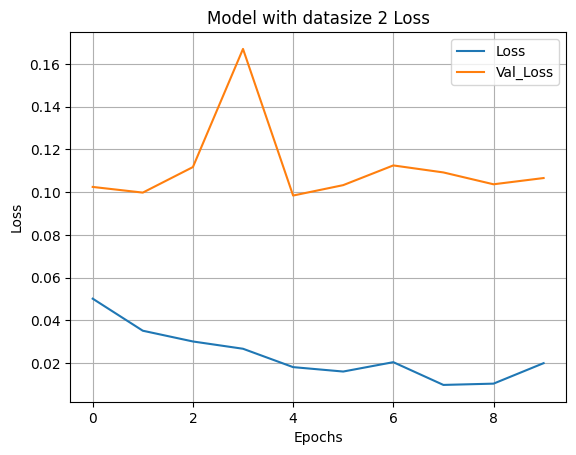

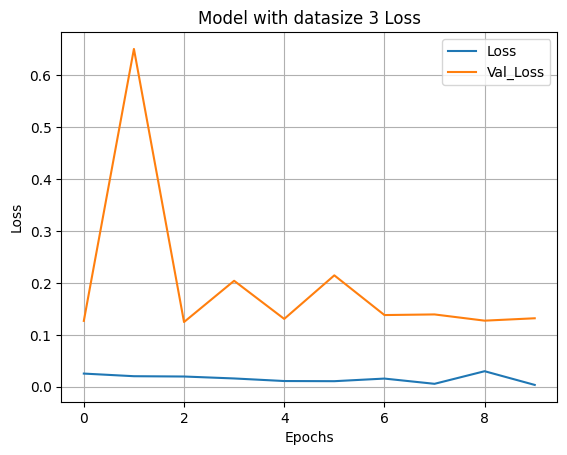

In [46]:
i = 1
for history in h_layers:
    plt.plot(history.history["loss"], label="Loss")
    plt.plot(history.history["val_loss"], label="Val_Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.title(f'Model with datasize {i} Loss')

    plt.legend()
    plt.grid()
    plt.show()
    i+=1

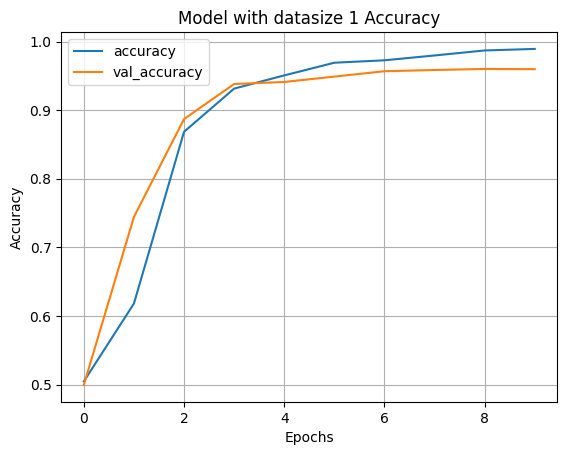

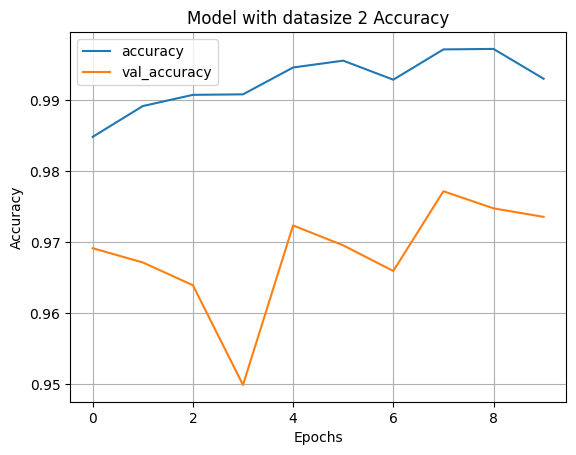

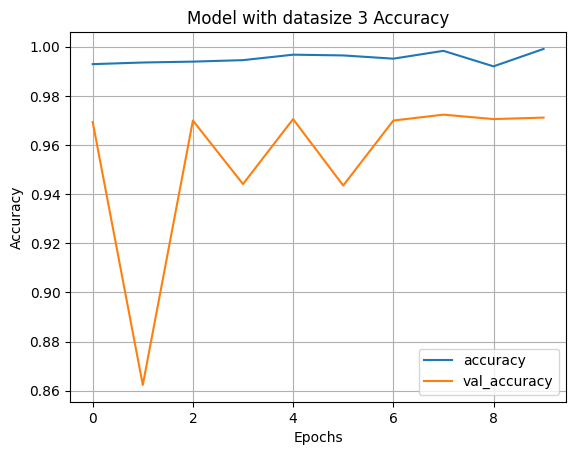

In [45]:
i = 1
for history in h_layers:
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.title(f'Model with datasize {i} Accuracy')

    plt.legend()
    plt.grid()
    plt.show()
    i+=1

In [43]:
for data in datasize:
    score = model.evaluate(data[4], data[6])
    print(f'Model {data[0].shape[0]}')
    print("Test loss: ", score[0])
    print("Test accuracy: ", score[1])


156/156 [==============================] - 2s 15ms/step - loss: 0.0643 - accuracy: 0.9842
Model 12480
Test loss:  0.06433795392513275
Test accuracy:  0.9841746687889099
117/117 [==============================] - 1s 12ms/step - loss: 0.0937 - accuracy: 0.9770
Model 14559
Test loss:  0.09365816414356232
Test accuracy:  0.9770299196243286
78/78 [==============================] - 1s 12ms/step - loss: 0.1172 - accuracy: 0.9704
Model 16640
Test loss:  0.11719102412462234
Test accuracy:  0.9703525900840759
